In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dadaptation
import random


from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import h5py
import os
import sys
import pickle
import json

from utilities3 import *
from sklearn.model_selection import train_test_split
from Adam import Adam
from timeit import default_timer
from collections import OrderedDict

# import local modules from FNO2D.py
import FNO2D


import wandb
import datetime

In [2]:
# get device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

PROJECT_NAME = 'FNO2D'

# Set the random seeds to improve reproducibility by removing stochasticity
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False # Force cuDNN to use a consistent convolution algorithm
    torch.backends.cudnn.deterministic = True # Force cuDNN to use deterministic algorithms if available
    torch.use_deterministic_algorithms(True) # Force torch to use deterministic algorithms if available

set_seeds(0)

# for deterministic pytorch algorithms, enable reproducibility.
os.environ['CUBLAS_WORKSPACE_CONFIG']= ":4096:8"

In [3]:
n_list = [32]

LOCAL_MODEL_DIR = 'Model/model_GeoFNO2D.pt'
LOCAL_MODEL_IPHI_DIR = 'Model/model_iphi_GeoFNO2D.pt'

INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 1

BATCH_SIZE = 16

In [4]:
# fetch coordinates from wandb
run = wandb.init(project=PROJECT_NAME, job_type="get_coordinates")
artifact = run.use_artifact('jyyresearch/FNO2D/fracture-damage-coordinates:latest', type='coordinates')
artifact_dir = artifact.download()

gc_coordinates = pd.read_csv(os.path.join(artifact_dir, 'gc_out_coord'), sep=",", header=None).to_numpy()
d_coordinates = pd.read_csv(os.path.join(artifact_dir, 'd_out_coord'), sep=",", header=None).to_numpy()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jyyresearch (use `wandb login --relogin` to force relogin)


In [5]:
print("gc coordinates shape: ", gc_coordinates.shape)

gc coordinates shape:  (13172, 2)


In [6]:
# load gc coordinate from interpolated_gc_data
gc_coordinates_interpolated = pd.read_csv("interpolated_gc_data/Gc_out_coord.txt", sep=",", header=None).to_numpy()
print("gc coordinates interpolated shape: ", gc_coordinates_interpolated.shape)

gc coordinates interpolated shape:  (13172, 2)


In [7]:
# load gc data from interpolated_gc_data
gc = np.load("interpolated_gc_data/gc_array.npy")
print("gc shape: ", gc.shape)

gc shape:  (5800, 13172)


In [8]:
# initialize model

# config for model
modes = 12
s = modes * 4
width = 32

model = FNO2D.FNO2d(modes, modes, width=width, in_channels=INPUT_CHANNELS, out_channels=OUTPUT_CHANNELS, s1=s, s2=s).cuda()
model_iphi = FNO2D.IPHI(width=width).cuda()

In [9]:
# get GeoFNO2D model from wandb
run = wandb.init(project=PROJECT_NAME, job_type="inference")
trained_model_at = run.use_artifact("GeoFNO2D:latest", type="model")
model_dir = trained_model_at.download()

# load best model
model = FNO2D.FNO2d(modes, modes, width=32, in_channels=3, out_channels=1, s1=s, s2=s).cuda()
model_iphi = FNO2D.IPHI(width=32).cuda()

model.load_state_dict(torch.load(os.path.join(model_dir, 'model_GeoFNO2D.pt')))
model_iphi.load_state_dict(torch.load(os.path.join(model_dir, 'model_iphi_GeoFNO2D.pt')))
run.finish()

In [10]:
damage_coordinates = pd.read_csv("interpolated_gc_data/mesh_ver_coord.txt", sep=",", header=None).to_numpy()
print("damage coordinates shape: ", damage_coordinates.shape)

damage coordinates shape:  (6736, 2)


In [11]:
# create numpy array with shape (len(gc), gc.shape[1], 2)
input_mesh = np.zeros((len(gc), gc.shape[1], 2))
damage_mesh = np.zeros((len(gc), damage_coordinates.shape[0], 2))



# for each sample in input_mesh, add the coordinates
for i in range(len(gc)):
    input_mesh[i, :, :] = gc_coordinates
    damage_mesh[i, :, :] = damage_coordinates
    
# add gc to the last dimension of input_mesh to have shape of (len(gc), gc.shape[1], 3)
gc_data = np.concatenate((input_mesh, np.expand_dims(gc, axis=2)), axis=2)

In [12]:
# gc data to tensor and cuda
gc_data = torch.from_numpy(gc_data).float().cuda()

# mesh data to tensor and cuda
damage_mesh = torch.from_numpy(damage_mesh).float().cuda()

In [13]:
output_list = []

model.eval()
with torch.no_grad():
    # predict in batches
    for i in range(0, len(gc_data), BATCH_SIZE):
        gc_data_batch = gc_data[i:i+BATCH_SIZE]
        damage_mesh_batch = damage_mesh[i:i+BATCH_SIZE]
        
        # predict
        output = model(gc_data_batch, iphi=model_iphi, x_in = gc_data_batch[:, :, :2], x_out = damage_mesh_batch)
        output_list.append(output.cpu().numpy())

In [22]:
output_list[0].shape

(16, 6736, 1)

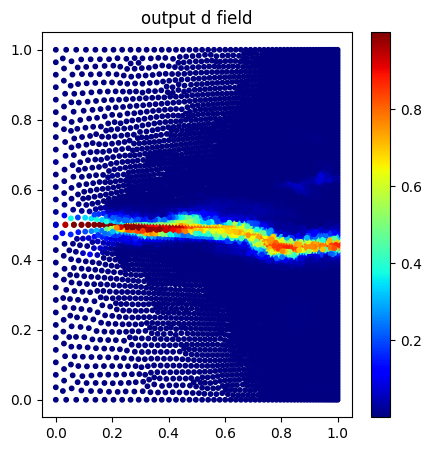

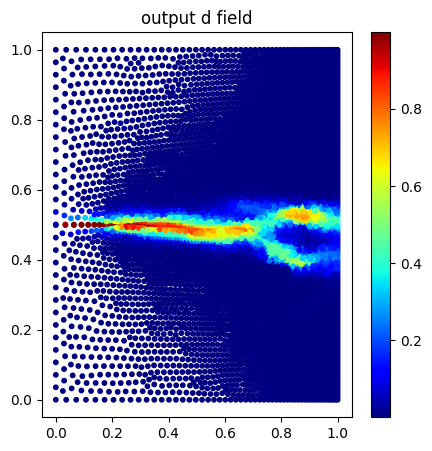

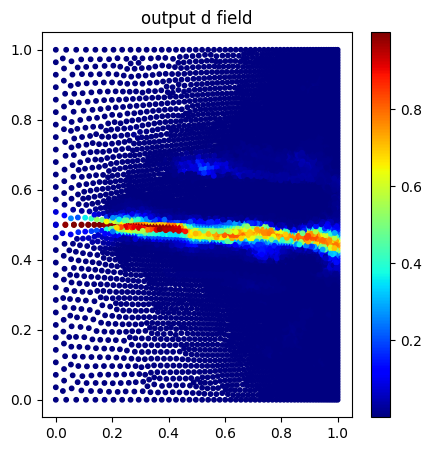

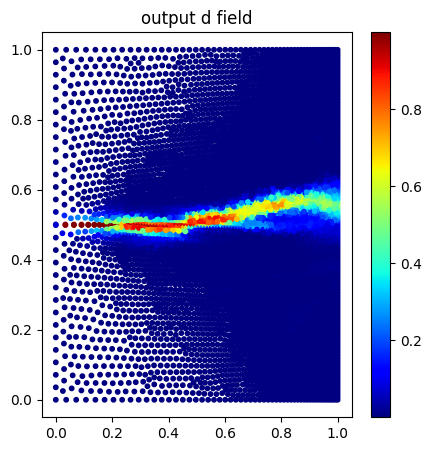

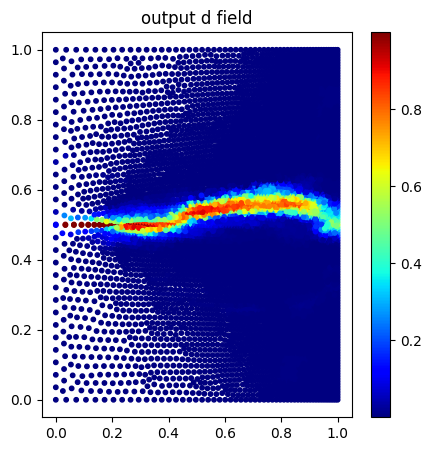

In [19]:
# plot 5 samples

damage_x = damage_coordinates[:, 0]
damage_y = damage_coordinates[:, 1]

for i in range(5):

    id1 = np.random.randint(0, len(gc)//BATCH_SIZE)
    id2 = np.random.randint(0, 16)

    plt.figure(figsize=(5, 5))
    plt.scatter(damage_x, damage_y, c=output_list[id1][id2][:, 0], cmap='jet', s=10)
    plt.colorbar()
    plt.title('output d field')

In [ ]:
# save output to npy file
output = np.concatenate(output_list, axis=0)
np.save("interpolated_gc_data/output.npy", output)